In [1]:
# Cell 1: imports & config

from __future__ import annotations



import joblib
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine, text

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
CONN_STR = (
    "mssql+pyodbc://rmir@RPTPRODDB/Alliance_RPT"
    "?driver=ODBC+Driver+18+for+SQL+Server"
    "&trusted_connection=yes"
    "&Encrypt=no"
)

engine = create_engine(CONN_STR)

In [9]:

# First, let's check the schema of the Files table in HSP_RPT database
files_columns_query = text("""
    SELECT COLUMN_NAME, DATA_TYPE
    FROM HSP_RPT.INFORMATION_SCHEMA.COLUMNS
    WHERE TABLE_NAME = 'Files'
    ORDER BY ORDINAL_POSITION
""")

with engine.connect() as conn:
    files_columns = pd.read_sql_query(files_columns_query, conn)

print("Columns in HSP_RPT.dbo.Files:")
print(files_columns)

# Check the schema of the documents table
docs_columns_query = text("""
    SELECT COLUMN_NAME, DATA_TYPE
    FROM HSP_RPT.INFORMATION_SCHEMA.COLUMNS
    WHERE TABLE_NAME = 'documents'
    ORDER BY ORDINAL_POSITION
""")

with engine.connect() as conn:
    docs_columns = pd.read_sql_query(docs_columns_query, conn)

print("\n\nColumns in HSP_RPT.dbo.documents:")
print(docs_columns)

# Query to get available tables
tables_query = text("""
    SELECT TABLE_SCHEMA, TABLE_NAME
    FROM INFORMATION_SCHEMA.TABLES
    WHERE TABLE_TYPE = 'BASE TABLE'
    ORDER BY TABLE_SCHEMA, TABLE_NAME
""")

with engine.connect() as conn:
    available_tables = pd.read_sql_query(tables_query, conn)
    conn.commit()
    engine.dispose()

# First, let's check what tables are actually available that might contain our data
print("\n\n Available tables in the database:")
print(available_tables)

# Search for tables that might contain Files or Documents
print("\n\nTables that might be relevant:")
relevant_tables = available_tables[
    available_tables['TABLE_NAME'].str.contains('File|Document|PDR', case=False, na=False)
]
relevant_tables

Columns in HSP_RPT.dbo.Files:
         COLUMN_NAME DATA_TYPE
0             FileID       int
1     TrackingNumber   varchar
2           ReasonID       int
3         SourceCode   varchar
4     IndividualCode   varchar
5       IndividualID       int
6   IndividualNumber   varchar
7         StatusCode   varchar
8            Subject   varchar
9         OpenedByID       int
10        ClosedByID       int
11           OwnerID       int
12     CurrentUserID       int
13            StepID       int
14      CallBackCode   varchar
15    CallBackNumber   varchar
16     ContactorName   varchar
17     ContactorType   varchar
18        DateOpened  datetime
19        DateClosed  datetime
20        FolderType   varchar
21      ParentFileId       int
22      ParentStepId       int
23       BillingCode   varchar
24    SupplementalId       int
25  SupplementalType   varchar
26     DateInitiated  datetime
27     TransactionId       int


Columns in HSP_RPT.dbo.documents:
             COLUMN_NAME DATA_TYPE


,TABLE_SCHEMA,TABLE_NAME
308,ATSA,COVIDIncentiveFFSExcelFiles
579,ATSA,JA_RecoupDataForPDR
618,ATSA,MC_Redetermination_Files
980,ATSA,temp_274File
1103,ATSA,therfile
...,...,...
4929,RPT,TEST_GINO_RRTESTING_DocumentRequests
4956,RPT,tmp_CommunitySupports_MemberProfile_Updates
4957,RPT,tmp_CommunitySupports_MemberProfile_UpdatesAuth
4958,RPT,tmp_CommunitySupports_MemberProfile_UpdatesMem...


In [2]:

# Now run the original query - you may need to adjust table names based on the output above
df = text("""
WITH pdr_files AS (                                                           
      -- Get all PDR case files
      SELECT
          FileID,
          TrackingNumber AS case_number,
          DateOpened AS case_date_opened,
          ReasonID
      FROM HSP_RPT.dbo.Files
      WHERE ReasonID IN (156,157,239)  -- PDR reason IDs
    ),

    document_mappings AS (
        -- Map files to document IDs (EntityType = 'WIN' for documents)
        SELECT
            FileId,
            EntityId AS DocumentID
        FROM HSP_RPT.dbo.FileEntityMap
        WHERE EntityType = 'WIN'
    ),

    claim_mappings AS (
        -- Get associated claim IDs for reference
      SELECT
          FileId,
          STRING_AGG(EntityId, ', ') AS claim_ids
      FROM HSP_RPT.dbo.FileEntityMap
      WHERE EntityType = 'CLM'
      GROUP BY FileId
  )

  SELECT
      pf.case_number,
      pf.case_date_opened,
      pf.ReasonID,
      d.DocumentID,
      d.DocumentNumber,
      d.Location,

      -- Build full UNC path (Windows)
      REPLACE(d.Location, 'domain', 'ccah-alliance.org') + d.DocumentNumber AS unc_path,

      -- Build Linux mount path
      REPLACE(
          REPLACE(
              REPLACE(d.Location, 'domain', 'ccah-alliance.org') + d.DocumentNumber,
              '\\\\ccah-alliance.org\\hspshare\\',
              '/hspshare/'
          ),
          '\\',
          '/'
      ) AS linux_path,

      cm.claim_ids,
      d.DateReceived AS document_date_received,
      d.DateFiled AS document_date_filed,
          o.Status AS pif_status

    FROM pdr_files pf
    INNER JOIN document_mappings dm
        ON pf.FileID = dm.FileId
    INNER JOIN HSP_RPT.dbo.documents d
        ON dm.DocumentID = d.DocumentID
    LEFT JOIN claim_mappings cm
        ON pf.FileID = cm.FileId
    left join Alliance_RPT.DataScience.PIF_ML_OPEN o
            ON pf.case_number = o.casenumber
    where o.status ='OPEN'
    ORDER BY pf.case_number, d.DocumentNumber

"""
)
with engine.connect() as conn:
    df = pd.read_sql_query(df, conn)
    conn.commit()
    engine.dispose()
    

###uppercase all columns
df.columns = df.columns.str.upper()


### look at top 100 rows
df.shape

(4057, 12)

In [4]:
df

,CASE_NUMBER,CASE_DATE_OPENED,REASONID,DOCUMENTID,DOCUMENTNUMBER,LOCATION,UNC_PATH,LINUX_PATH,CLAIM_IDS,DOCUMENT_DATE_RECEIVED,DOCUMENT_DATE_FILED,PIF_STATUS
0,FL023500619,2025-02-21 00:00:00.000,239,86902820,DOC86786310.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/02...,None,2025-02-25 16:12:36.117,2025-02-25 16:12:36.177,OPEN
1,FL023500619,2025-02-21 00:00:00.000,239,86902821,TRN24817716.pdf,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/02...,None,2025-02-25 16:12:36.117,2025-02-25 16:12:36.237,OPEN
2,FL024787768,2025-06-18 14:42:15.987,156,91817712,DOC91817712.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/06...,48923540,2025-06-18 14:42:16.060,2025-06-18 14:42:16.063,OPEN
3,FL024787918,2025-06-18 14:47:35.170,156,91817731,DOC91817731.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/06...,51058054,2025-06-18 14:47:35.283,2025-06-18 14:47:35.283,OPEN
4,FL024787931,2025-06-18 14:48:21.400,156,91817734,DOC91817734.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/06...,52417354,2025-06-18 14:48:21.490,2025-06-18 14:48:21.490,OPEN
...,...,...,...,...,...,...,...,...,...,...,...,...
4052,FL027721490,2026-02-10 10:57:10.087,156,102147771,DOC02147771.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2026/02...,55203472,2026-02-10 10:57:10.210,2026-02-10 10:57:10.210,OPEN
4053,FL027721550,2026-02-10 10:58:07.843,156,102147783,DOC02147783.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2026/02...,55034679,2026-02-10 10:58:07.977,2026-02-10 10:58:07.977,OPEN
4054,FL027721575,2026-02-10 10:58:26.803,156,102147789,DOC02147789.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2026/02...,55063940,2026-02-10 10:58:26.913,2026-02-10 10:58:26.913,OPEN
4055,FL027721633,2026-02-10 10:59:14.390,156,102147800,DOC02147800.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2026/02...,59410693,2026-02-10 10:59:14.493,2026-02-10 10:59:14.497,OPEN


In [3]:
df[df['CASE_NUMBER'] == 'FL0262436991']

,CASE_NUMBER,CASE_DATE_OPENED,REASONID,DOCUMENTID,DOCUMENTNUMBER,LOCATION,UNC_PATH,LINUX_PATH,CLAIM_IDS,DOCUMENT_DATE_RECEIVED,DOCUMENT_DATE_FILED,PIF_STATUS


File path: /hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/09/24/Attachments/DOC96050784.TIF
Successfully opened image: /hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/09/24/Attachments/DOC96050784.TIF


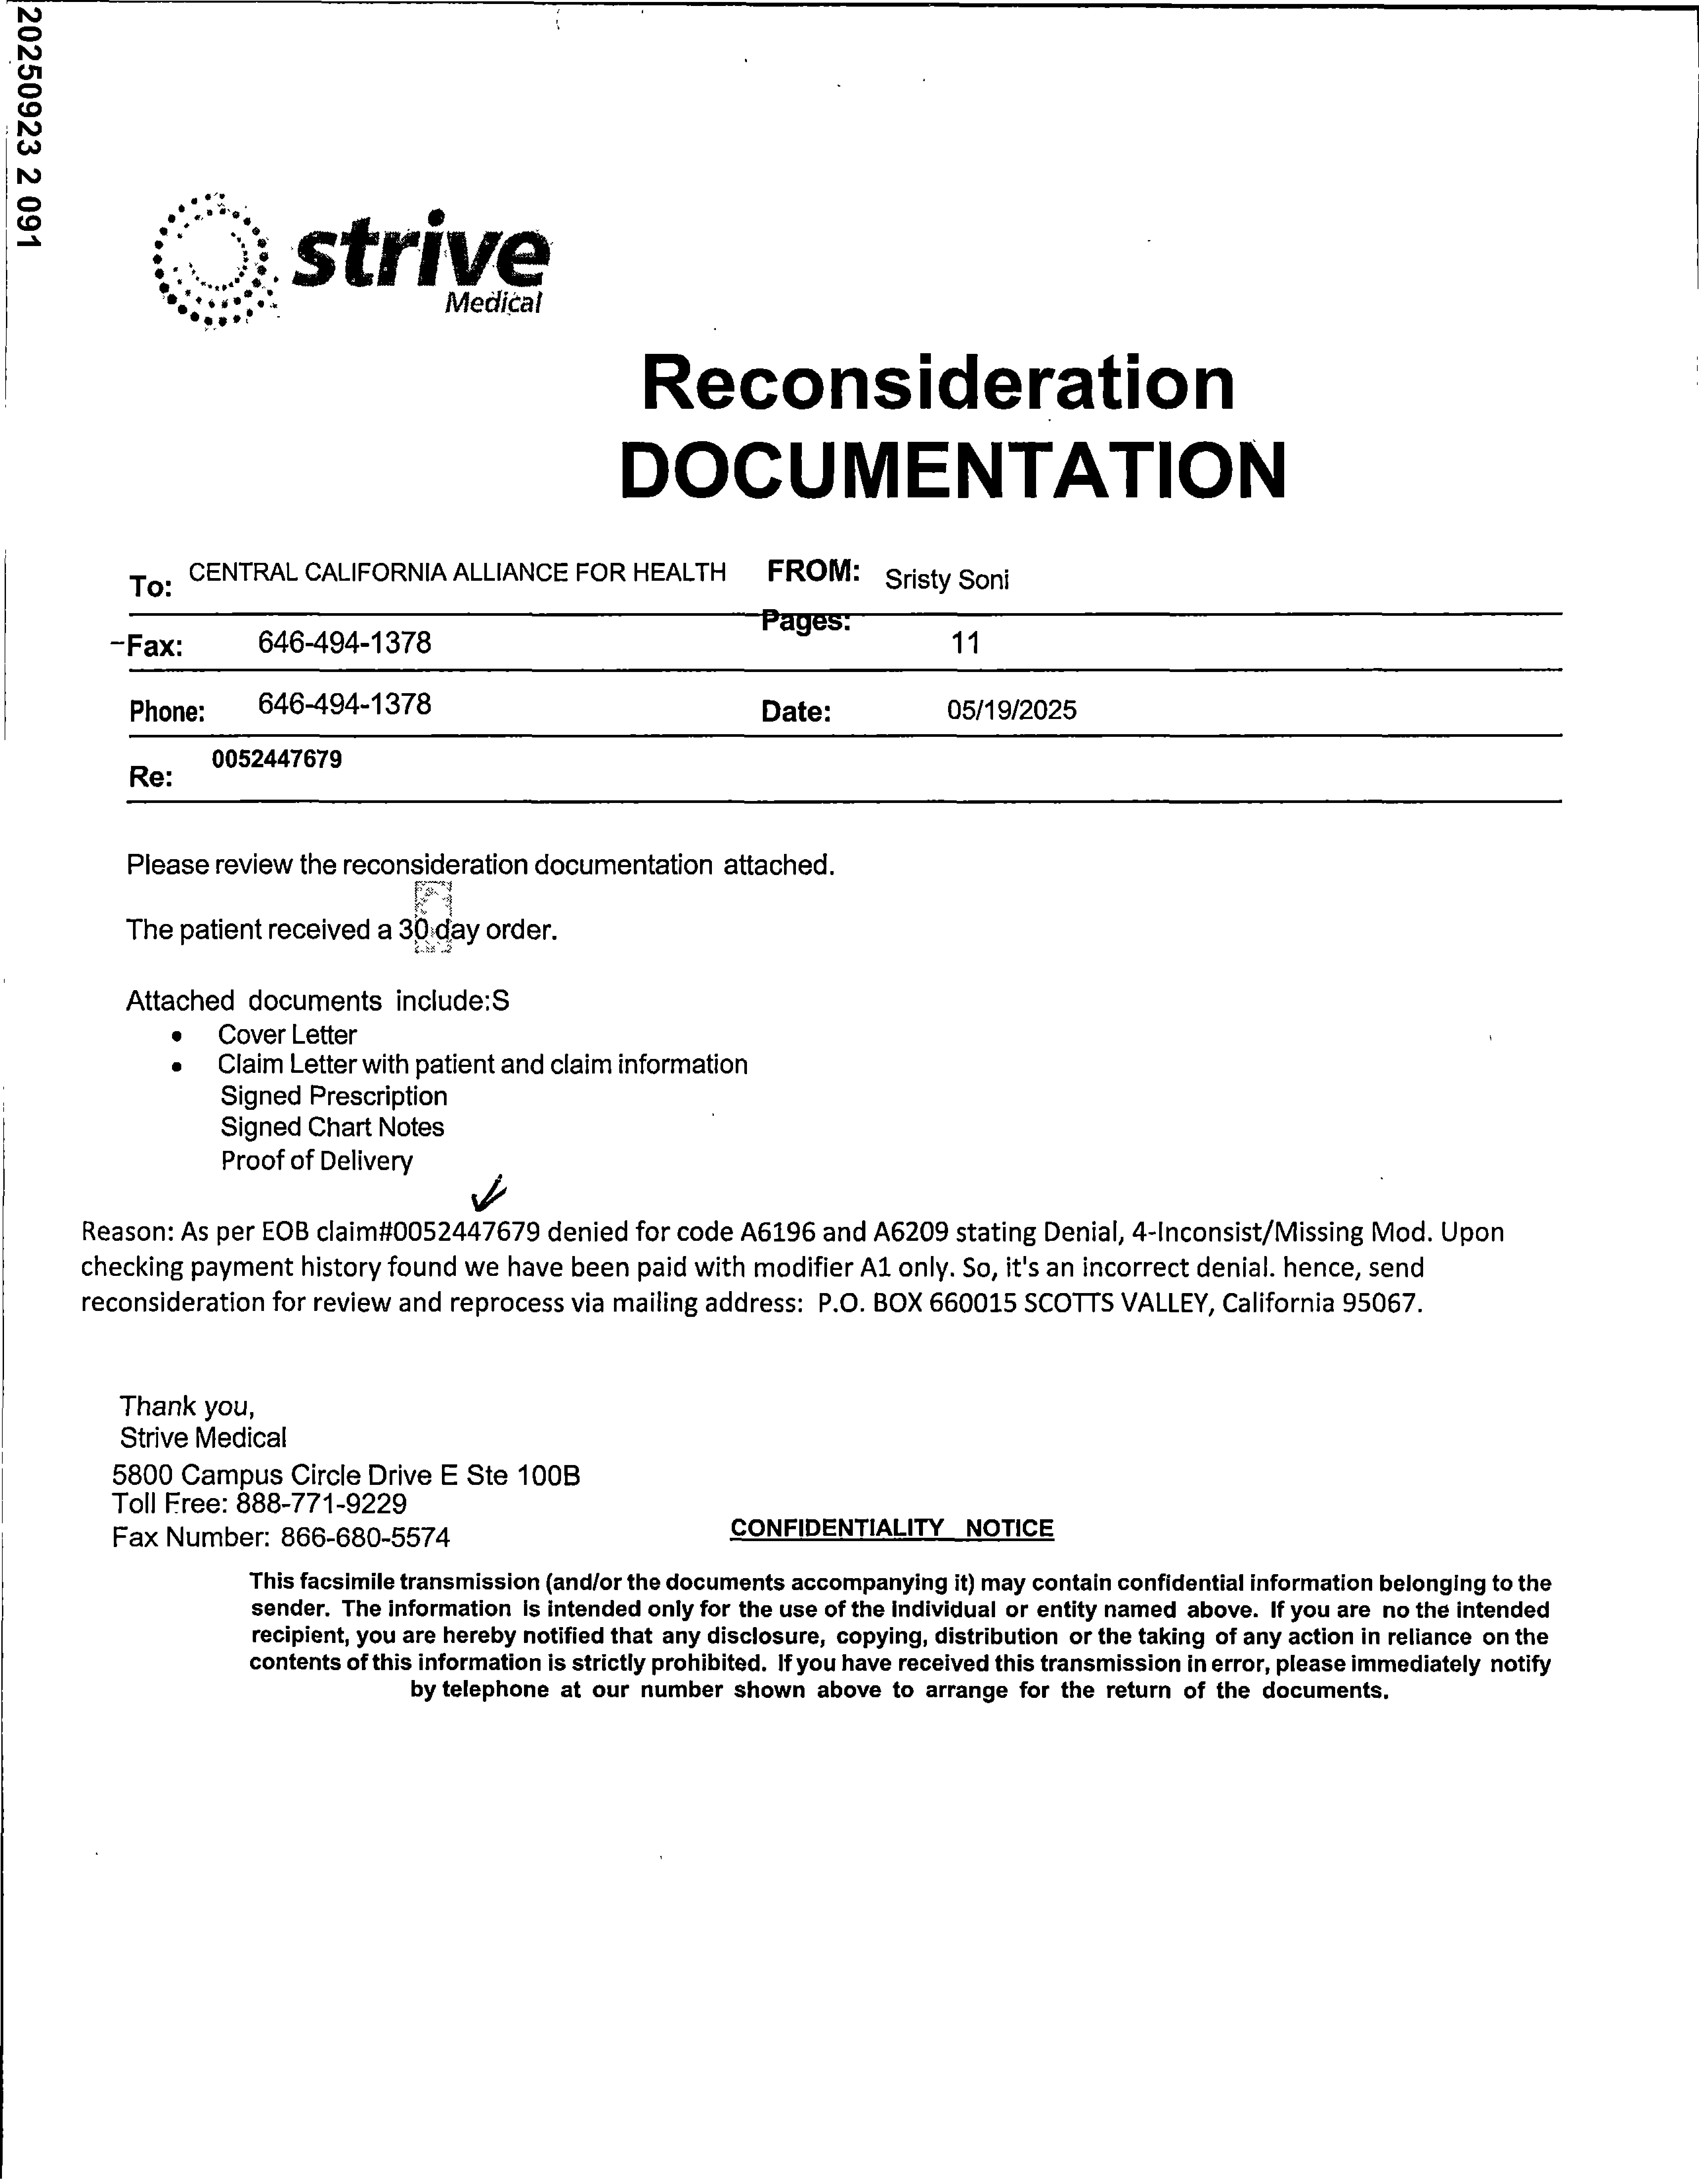

MissingSchema: Invalid URL '/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/09/24/Attachments/DOC96050784.TIF': No scheme supplied. Perhaps you meant https:///hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/09/24/Attachments/DOC96050784.TIF?

In [11]:
df[df['CASE_NUMBER'] == 'FL025896931']
### lets open and display the image for this case number
from PIL import Image

# Get the file path (it's a local Linux path, not a URL)
file_path = df[df['CASE_NUMBER'] == 'FL025896931']['LINUX_PATH'].values[0]
print(f"File path: {file_path}")

try:
    # Open the image directly from the local file path
    img = Image.open(file_path)
    print(f"Successfully opened image: {file_path}")
    display(img)
except Exception as e:
    print(f"Error opening image {file_path}: {e}")
import requests
from io import BytesIO  
url = df[df['CASE_NUMBER'] == 'FL025896931']['LINUX_PATH'].values[0]    
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.show()


In [3]:
##rank df based on  case_date_opened column in descending order (most recent cases first)
df['CASE_DATE_OPENED'] = pd.to_datetime(df['CASE_DATE_OPENED'])
df = df.sort_values(by='CASE_DATE_OPENED', ascending=False)
df

,CASE_NUMBER,CASE_DATE_OPENED,REASONID,DOCUMENTID,DOCUMENTNUMBER,LOCATION,UNC_PATH,LINUX_PATH,CLAIM_IDS,DOCUMENT_DATE_RECEIVED,DOCUMENT_DATE_FILED,PIF_STATUS
99,FL026070922,2025-10-07 10:33:15.753,156,96615269,DOC96615269.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/10...,53860336,2025-10-07 10:33:15.843,2025-10-07 10:33:15.843,OPEN
98,FL026053383,2025-10-06 10:36:19.033,156,96552453,DOC96552453.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/10...,54179424,2025-10-06 10:36:19.110,2025-10-06 10:36:19.110,OPEN
97,FL026053222,2025-10-06 10:30:58.000,156,96552436,DOC96552436.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/10...,53942635,2025-10-06 10:30:58.143,2025-10-06 10:30:58.150,OPEN
96,FL026053221,2025-10-06 10:30:55.060,156,96552435,DOC96552435.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/10...,53826217,2025-10-06 10:30:55.143,2025-10-06 10:30:55.143,OPEN
95,FL026053106,2025-10-06 10:27:44.397,156,96552421,DOC96552421.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/10...,53785176,2025-10-06 10:27:44.470,2025-10-06 10:27:44.470,OPEN
...,...,...,...,...,...,...,...,...,...,...,...,...
4,FL024787931,2025-06-18 14:48:21.400,156,91817734,DOC91817734.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/06...,52417354,2025-06-18 14:48:21.490,2025-06-18 14:48:21.490,OPEN
3,FL024787918,2025-06-18 14:47:35.170,156,91817731,DOC91817731.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/06...,51058054,2025-06-18 14:47:35.283,2025-06-18 14:47:35.283,OPEN
2,FL024787768,2025-06-18 14:42:15.987,156,91817712,DOC91817712.TIF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/06...,48923540,2025-06-18 14:42:16.060,2025-06-18 14:42:16.063,OPEN
1,FL023500619,2025-02-21 00:00:00.000,239,86902821,TRN24817716.pdf,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/02...,None,2025-02-25 16:12:36.117,2025-02-25 16:12:36.237,OPEN


Attempting to read and display the first page of the PDF (preview only): /hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/02/25/Attachments/TRN24817716.pdf
Successfully read the PDF (showing page 1 of potentially multiple pages): /hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/02/25/Attachments/TRN24817716.pdf


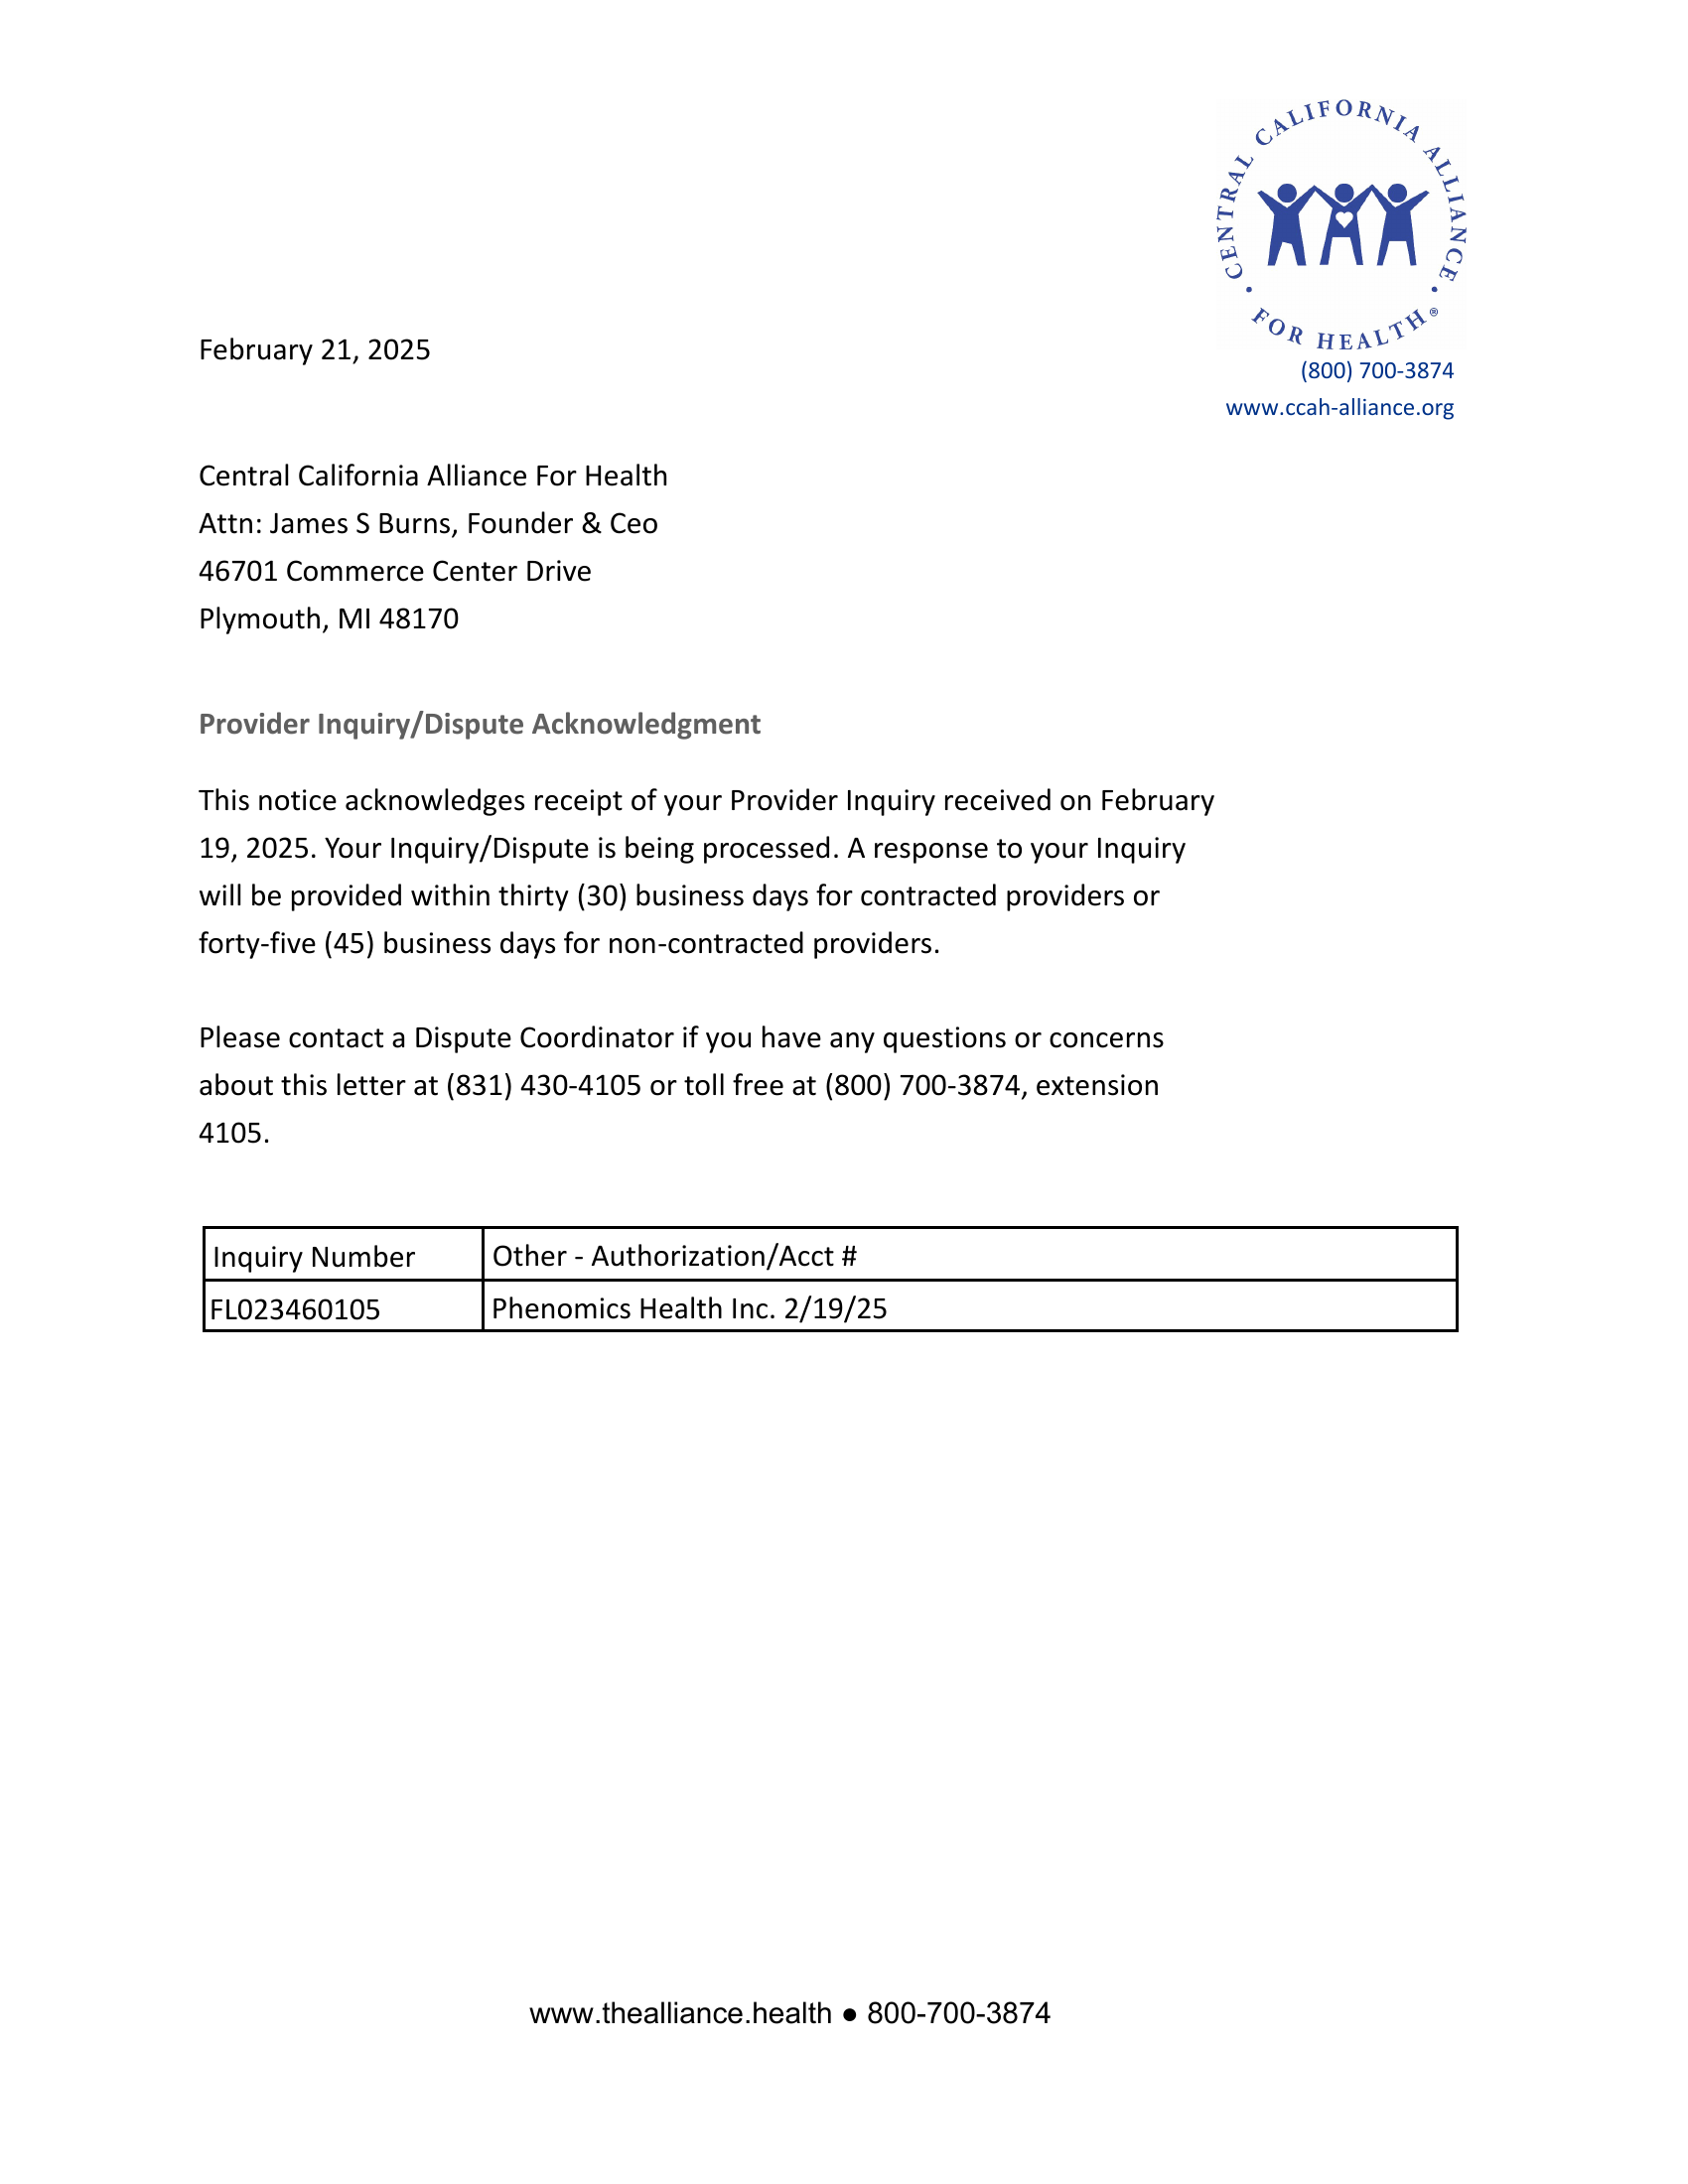

Processed 10/90 cases...
Processed 20/90 cases...
Processed 30/90 cases...
Processed 40/90 cases...
Processed 50/90 cases...
Processed 60/90 cases...
Processed 70/90 cases...
Processed 80/90 cases...
Processed 90/90 cases...

Conversion complete! Results saved to /hspshare/converted_images
status
success    90
Name: count, dtype: int64

Successfully processed 90 cases
Total images combined: 891
Average images per case: 9.9

Example cases:
  Case FL023500619: 2 files, 6 images → FL023500619_combined.png
  Case FL024459801: 4 files, 28 images → FL024459801_combined.png
  Case FL024460196: 4 files, 24 images → FL024460196_combined.png


In [ ]:
import os
from PIL import Image
from pdf2image import convert_from_path
from pathlib import Path
import pandas as pd

# Create base output folder
base_output_folder = Path('/hspshare/converted_images')
base_output_folder.mkdir(parents=True, exist_ok=True)

# Ensure case numbers are valid and not empty
df = df[df['CASE_NUMBER'].notna()]

# Read and display one of the original PDF files before conversion (preview only)
sample_pdf = df[df['LINUX_PATH'].str.lower().str.endswith('.pdf', na=False)].iloc[0]
pdf_path = sample_pdf['LINUX_PATH']

print(f"Attempting to read and display the first page of the PDF (preview only): {pdf_path}")

try:
    # Convert the first page of the PDF to an image for preview
    images = convert_from_path(pdf_path, first_page=1, last_page=1)
    print(f"Successfully read the PDF (showing page 1 of potentially multiple pages): {pdf_path}")
    display(images[0])
except Exception as e:
    print(f"Error reading the PDF {pdf_path}: {e}")

# Group files by case number and combine all images into one PNG per case
conversion_log = []

# Group dataframe by case number
grouped_cases = df.groupby('CASE_NUMBER')
total_cases = len(grouped_cases)

for case_idx, (case_number, case_group) in enumerate(grouped_cases, 1):
    case_number = str(case_number).strip()
    
    # Skip rows with invalid case numbers
    if not case_number:
        conversion_log.append({'case': case_number, 'status': 'skipped', 'type': 'invalid_case', 'files_count': 0})
        continue

    # Create a subdirectory for each case
    case_output_folder = base_output_folder / case_number
    case_output_folder.mkdir(parents=True, exist_ok=True)

    # Collect all images from this case
    all_images = []
    processed_files = []
    
    for idx, row in case_group.iterrows():
        file_path = row['LINUX_PATH']
        file_name = row['DOCUMENTNUMBER']
        file_ext = Path(file_path).suffix.lower()

        try:
            if file_ext == '.pdf':
                # Convert ALL pages of PDF to images (not just first page)
                pdf_images = convert_from_path(file_path)  # Gets all pages by default
                all_images.extend(pdf_images)
                # print(f"  Converted {len(pdf_images)} pages from PDF: {file_name}")
                processed_files.append({'file': file_name, 'type': 'pdf', 'pages': len(pdf_images)})
                
            elif file_ext in ['.tif', '.tiff']:
                # Open ALL frames/pages of TIF file (multi-page TIFF support)
                tif_images = []
                with Image.open(file_path) as tif_image:
                    try:
                        while True:
                            tif_images.append(tif_image.copy())
                            tif_image.seek(tif_image.tell() + 1)  # Move to next frame
                    except EOFError:
                        pass  # End of frames reached
                
                all_images.extend(tif_images)
                # print(f"  Converted {len(tif_images)} pages from TIFF: {file_name}")
                processed_files.append({'file': file_name, 'type': 'tif', 'pages': len(tif_images)})
                
            else:
                processed_files.append({'file': file_name, 'type': 'other', 'status': 'skipped'})
                
        except Exception as e:
            processed_files.append({'file': file_name, 'type': 'error', 'error': str(e)})

    # Combine all images into one PNG if we have any images
    if all_images:
        try:
            # Calculate dimensions for the combined image
            max_width = max(img.width for img in all_images)
            total_height = sum(img.height for img in all_images)
            
            # Create a new blank image with the combined dimensions
            combined_image = Image.new('RGB', (max_width, total_height), 'white')
            
            # Paste all images vertically
            y_offset = 0
            for img in all_images:
                # Convert to RGB if needed (for consistency)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                combined_image.paste(img, (0, y_offset))
                y_offset += img.height
            
            # Save the combined image as PNG
            output_path = case_output_folder / f"{case_number}_combined.png"
            combined_image.save(output_path, 'PNG')
            
            conversion_log.append({
                'case': case_number, 
                'status': 'success', 
                'files_count': len(processed_files),
                'total_images': len(all_images),
                'output_file': f"{case_number}_combined.png",
                'processed_files': processed_files
            })
            
        except Exception as e:
            conversion_log.append({
                'case': case_number, 
                'status': 'error', 
                'error': str(e),
                'files_count': len(processed_files),
                'processed_files': processed_files
            })
    else:
        conversion_log.append({
            'case': case_number, 
            'status': 'no_images', 
            'files_count': len(processed_files),
            'processed_files': processed_files
        })

    if case_idx % 10 == 0:
        print(f"Processed {case_idx}/{total_cases} cases...")

conversion_df = pd.DataFrame(conversion_log)
print(f"\nConversion complete! Results saved to {base_output_folder}")
print(conversion_df['status'].value_counts())

# Display summary of processed files per case
successful_cases = conversion_df[conversion_df['status'] == 'success']
if not successful_cases.empty:
    print(f"\nSuccessfully processed {len(successful_cases)} cases")
    print(f"Total images combined: {successful_cases['total_images'].sum()}")
    print(f"Average images per case: {successful_cases['total_images'].mean():.1f}")
    

Attempting to display and compress combined file: /hspshare/converted_images/FL023500619/FL023500619_combined.png
Original file size: 1.4 MB
Successfully opened: /hspshare/converted_images/FL023500619/FL023500619_combined.png
Original image dimensions: 6662 x 29390 pixels
Resizing to: 453 x 2000 pixels
Creating compressed version...
Compressed file size: 0.1 MB (saved 95.3%)


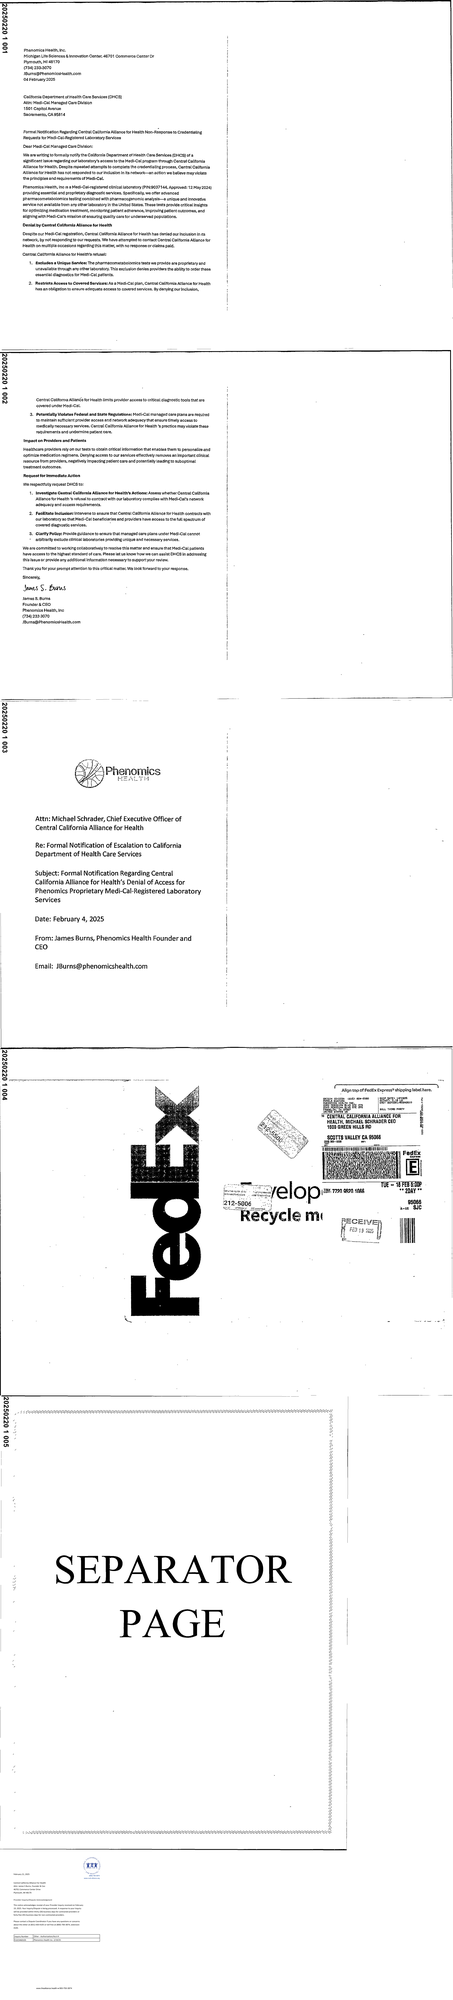


Compressed version saved as: /hspshare/converted_images/FL023500619/FL023500619_compressed.jpg


In [28]:
#### Display specific combined PNG example: FL023500619_combined.png (with compression)
from PIL import Image
from IPython.display import display
import io

# Increase PIL's image size limit to handle large combined images
Image.MAX_IMAGE_PIXELS = None  # Remove the limit entirely

# Specify the case number and construct the path
case_number = "FL023500619"
combined_file_path = base_output_folder / case_number / f"{case_number}_combined.png"
compressed_file_path = base_output_folder / case_number / f"{case_number}_compressed.jpg"

print(f"Attempting to display and compress combined file: {combined_file_path}")

try:
    if combined_file_path.exists():
        # Get file size first
        file_size_mb = combined_file_path.stat().st_size / (1024 * 1024)
        print(f"Original file size: {file_size_mb:.1f} MB")
        
        img = Image.open(combined_file_path)
        print(f"Successfully opened: {combined_file_path}")
        print(f"Original image dimensions: {img.width} x {img.height} pixels")
        
        # Create a compressed version for display
        # First resize to reasonable dimensions
        max_width = 1200
        max_height = 2000
        
        # Calculate resize ratio to fit within bounds
        width_ratio = max_width / img.width if img.width > max_width else 1
        height_ratio = max_height / img.height if img.height > max_height else 1
        resize_ratio = min(width_ratio, height_ratio)
        
        if resize_ratio < 1:
            new_width = int(img.width * resize_ratio)
            new_height = int(img.height * resize_ratio)
            print(f"Resizing to: {new_width} x {new_height} pixels")
            compressed_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
        else:
            compressed_img = img.copy()
        
        # Save compressed version as JPEG with reduced quality
        print("Creating compressed version...")
        compressed_img.save(compressed_file_path, 'JPEG', quality=70, optimize=True)
        
        # Get compressed file size
        compressed_size_mb = compressed_file_path.stat().st_size / (1024 * 1024)
        compression_ratio = (file_size_mb - compressed_size_mb) / file_size_mb * 100
        print(f"Compressed file size: {compressed_size_mb:.1f} MB (saved {compression_ratio:.1f}%)")
        
        # Display the compressed image
        display(compressed_img)
        
        # Clean up memory
        img.close()
        compressed_img.close()
        
        print(f"\nCompressed version saved as: {compressed_file_path}")
        
    else:
        print(f"Combined file not found: {combined_file_path}")
        print("Available case folders:")
        if base_output_folder.exists():
            case_folders = [f.name for f in base_output_folder.iterdir() if f.is_dir()]
            print(case_folders[:10])  # Show first 10 case folders
except Exception as e:
    print(f"Error processing the file {combined_file_path}: {e}")
    print("This might be due to the very large image size. The image may be too large to process in memory.")

In [28]:
### can we try to read some of these png files to see if they look correct?
sample_files = conversion_df[conversion_df['status'] == 'success']['file'].head(5)
for file in sample_files:   
    img_path = output_folder / (Path(file).stem + '.png')
    try:
        img = Image.open(img_path)
        print(f"Successfully opened {img_path}")
        display(img)
    except Exception as e:
        print(f"Error opening {img_path}: {e}")

In [11]:
df[df['CASE_NUMBER']=='FL010008070']


,CASE_NUMBER,CASE_DATE_OPENED,REASONID,DOCUMENTID,DOCUMENTNUMBER,LOCATION,UNC_PATH,LINUX_PATH,CLAIM_IDS,DOCUMENT_DATE_RECEIVED,DOCUMENT_DATE_FILED
0,FL010008070,2020-02-06 16:32:48.400,31,34179497,DOC34179497.PDF,\\domain\hspshare\HSPPRODDB\HSP\DOCUMENTS\DONE...,\\ccah-alliance.org\hspshare\HSPPRODDB\HSP\DOC...,/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2020/02...,None,2020-02-06 16:54:52.123,2020-02-06 16:54:52.140


Testing with case: FL023500619
PDF file: /hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/02/25/Attachments/TRN24817716.pdf
Successfully opened /hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/02/25/Attachments/TRN24817716.pdf (showing page 1 for preview)


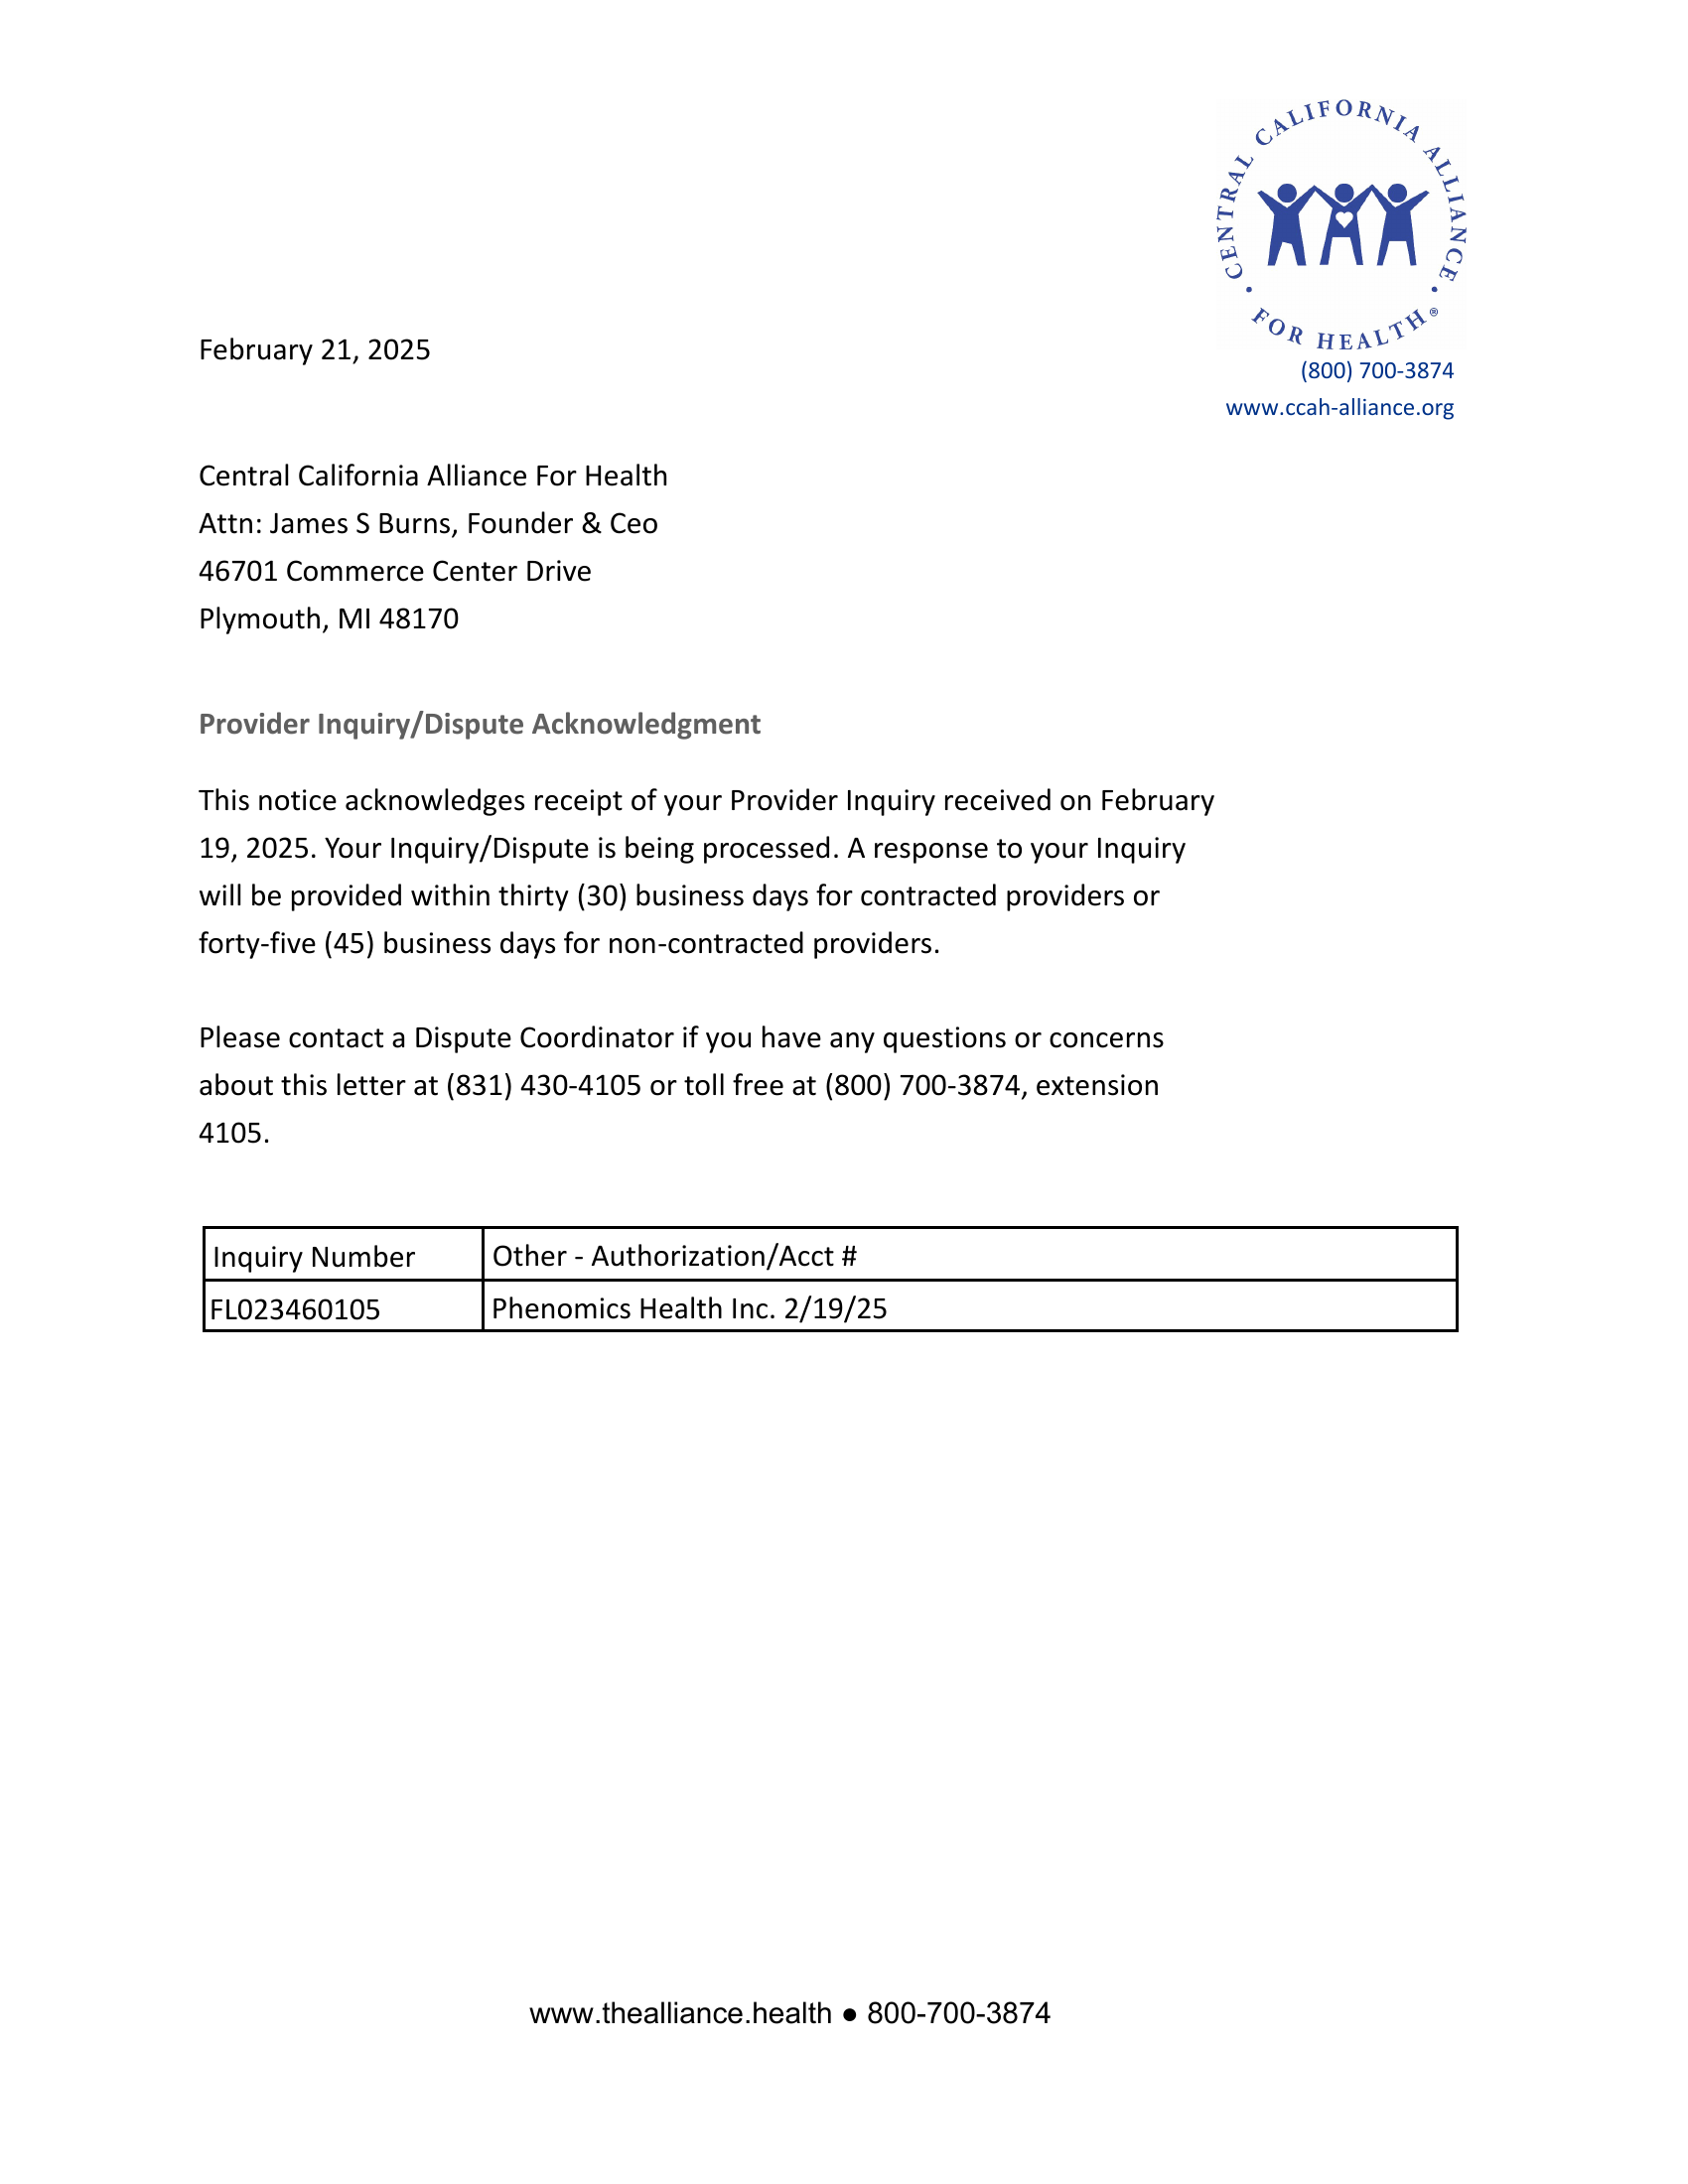

In [26]:
### Test: open one of the pdf files directly (preview - first page only)
# Use LINUX_PATH instead of UNC_PATH for Linux compatibility

# Get the first case with PDF files from the dataset
pdf_cases = df[df['LINUX_PATH'].str.lower().str.endswith('.pdf', na=False)]
if not pdf_cases.empty:
    case_number = pdf_cases['CASE_NUMBER'].iloc[0]
    pdf_path = pdf_cases['LINUX_PATH'].iloc[0]
    
    print(f"Testing with case: {case_number}")
    print(f"PDF file: {pdf_path}")
    
    try:
        # For PDF files, use pdf2image to convert first page for preview
        if pdf_path.lower().endswith('.pdf'):
            images = convert_from_path(pdf_path, first_page=1, last_page=1)
            print(f"Successfully opened {pdf_path} (showing page 1 for preview)")
            display(images[0])
        else:
            img = Image.open(pdf_path)
            print(f"Successfully opened {pdf_path}")
            display(img)
    except Exception as e:
        print(f"Error opening {pdf_path}: {e}")
else:
    print("No PDF files found in the dataset")

In [20]:
df[df['CASE_NUMBER']=='FL010008070']['LINUX_PATH'].iloc[0]

'/hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2020/02/06/Attachments/DOC34179497.PDF'

In [53]:
### find tif files and try to open one of those as well
tif_files = conversion_df[conversion_df['type'] == 'tif']['file']
if not tif_files.empty:
    tif_file = tif_files.iloc[0]
    tif_path = output_folder / (Path(tif_file).stem + '.png')
    try:
        img = Image.open(tif_path)
        print(f"Successfully opened {tif_path}")
        display(img)
    except Exception as e:
        print(f"Error opening {tif_path}: {e}")

In [55]:
tif_files

Series([], Name: file, dtype: object)

In [ ]:
### Read and display combined images from the converted folders
from IPython.display import display

# Ensure there are successful conversions
successful_cases = conversion_df[conversion_df['status'] == 'success']
if successful_cases.empty:
    print("No successful conversions to display.")
else:
    # Sample a few cases to verify the combined images
    sample_cases = successful_cases['case'].head(3)

    for case in sample_cases:
        case_folder = base_output_folder / case
        combined_file = case_folder / f"{case}_combined.png"
        
        print(f"\nDisplaying combined image from case: {case}")
        print(f"File: {combined_file}")

        try:
            if combined_file.exists():
                img = Image.open(combined_file)
                print(f"Image size: {img.width} x {img.height} pixels")
                
                # Display the combined image (resize if too large for display)
                display_img = img
                if img.height > 2000:  # Resize large images for better display
                    ratio = 2000 / img.height
                    new_width = int(img.width * ratio)
                    display_img = img.resize((new_width, 2000))
                    print(f"Resized for display: {display_img.width} x {display_img.height} pixels")
                
                display(display_img)
            else:
                print(f"Combined file not found: {combined_file}")
        except Exception as e:
            print(f"Error reading combined image {combined_file}: {e}")

No successful conversions to display.


In [32]:
sample_cases


array([], dtype=object)

Attempting to read and display the first page of the PDF (preview only): /hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/02/25/Attachments/TRN24817716.pdf
Successfully read the PDF (showing page 1 for preview): /hspshare/HSPPRODDB/HSP/DOCUMENTS/DONE/2025/02/25/Attachments/TRN24817716.pdf


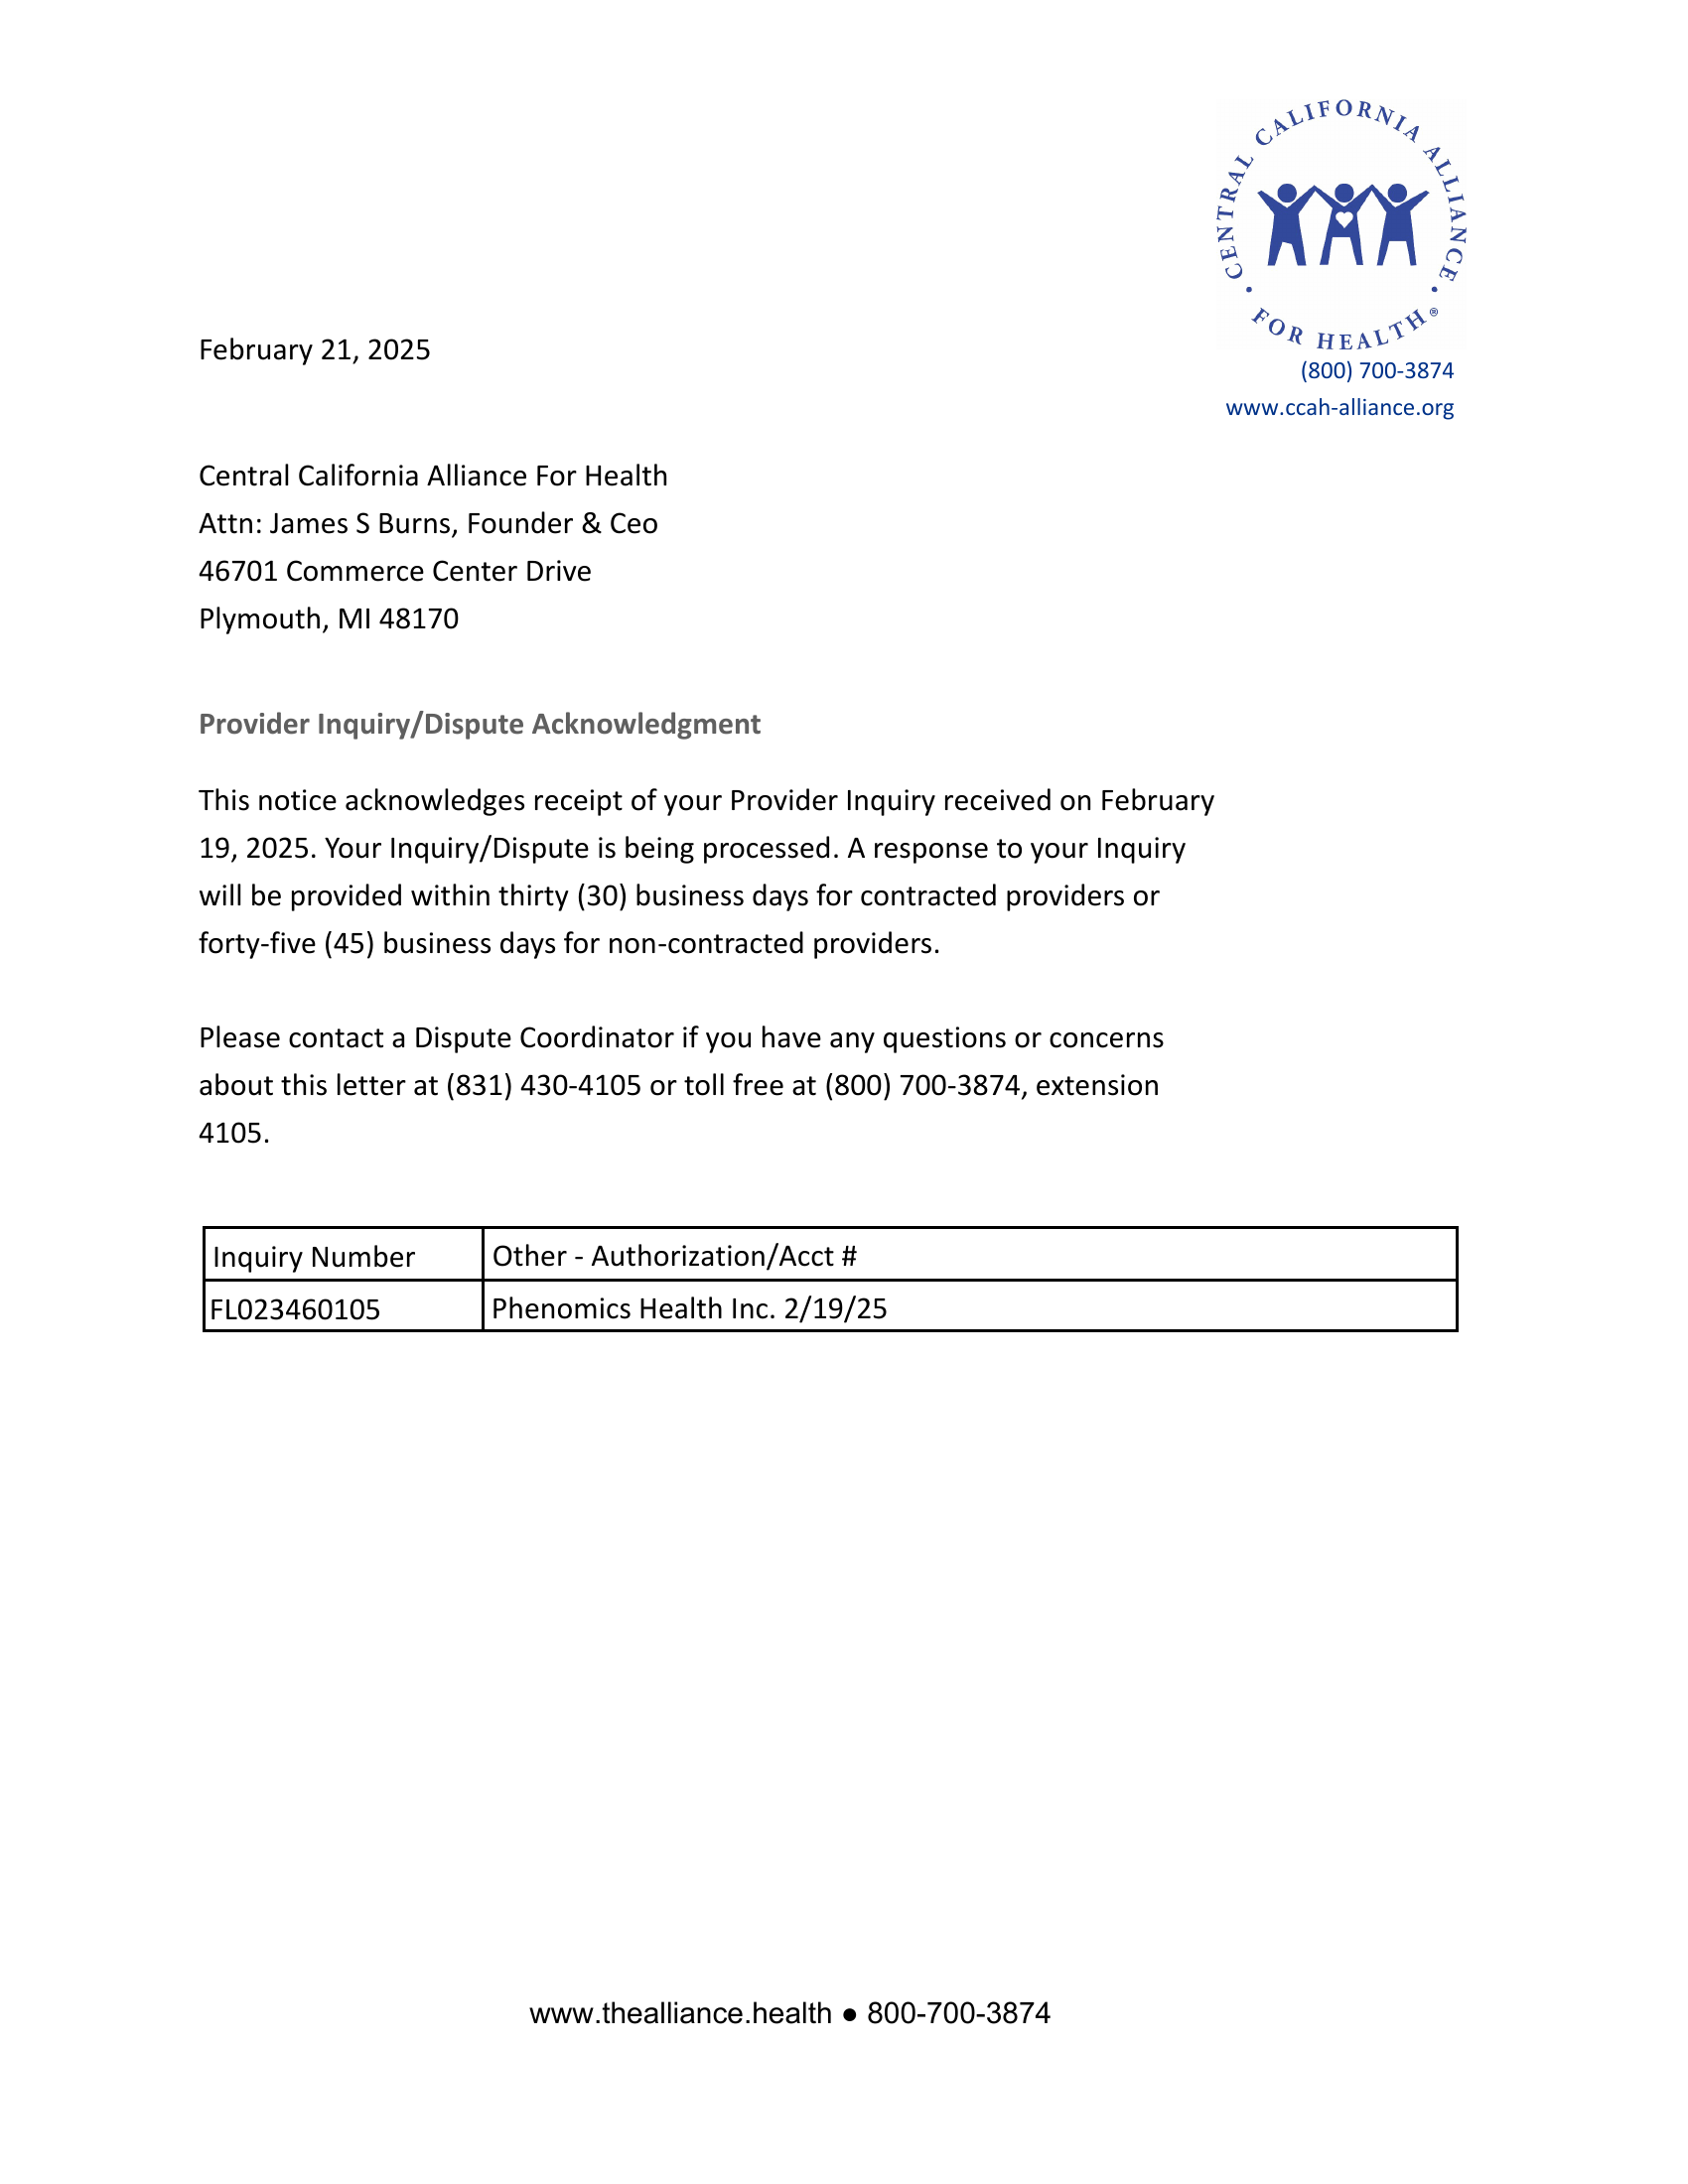

In [27]:
### Read and display one of the original PDF files (preview - first page only)
from pdf2image import convert_from_path

# Find a sample PDF file from the dataframe
sample_pdf = df[df['LINUX_PATH'].str.endswith('.pdf', na=False)].iloc[0]
pdf_path = sample_pdf['LINUX_PATH']

print(f"Attempting to read and display the first page of the PDF (preview only): {pdf_path}")

try:
    # Convert the first page of the PDF to an image for preview
    images = convert_from_path(pdf_path, first_page=1, last_page=1)
    print(f"Successfully read the PDF (showing page 1 for preview): {pdf_path}")
    display(images[0])
except Exception as e:
    print(f"Error reading the PDF {pdf_path}: {e}")

In [43]:
### Analyze conversion results and inspect file types

# Display the conversion log to understand errors and skipped files
print("Conversion Log Summary:")
print(conversion_df['status'].value_counts())

# Check the types of files that were skipped or caused errors
skipped_or_error_files = conversion_df[conversion_df['status'].isin(['skipped', 'error'])]

# Group by file type to see the distribution
file_types = skipped_or_error_files['type'].value_counts()
print("\nFile types of skipped or error files:")
print(file_types)

# Display a few examples of skipped or error files
print("\nExamples of skipped or error files:")
print(skipped_or_error_files.head())

Conversion Log Summary:
status
error      247
skipped     47
success     17
Name: count, dtype: int64

File types of skipped or error files:
type
other    47
Name: count, dtype: int64

Examples of skipped or error files:
              file status                                              error  \
0  DOC34179497.PDF  error  Unable to get page count.\nI/O Error: Couldn't...   
1  DOC34179496.PDF  error  Unable to get page count.\nI/O Error: Couldn't...   
2  DOC34209480.PDF  error  Unable to get page count.\nI/O Error: Couldn't...   
3  DOC34209481.PDF  error  Unable to get page count.\nI/O Error: Couldn't...   
4  DOC34256845.PDF  error  Unable to get page count.\nI/O Error: Couldn't...   

          case type  
0  FL010008070  NaN  
1  FL010008276  NaN  
2  FL010017096  NaN  
3  FL010017096  NaN  
4  FL010025496  NaN  


In [ ]:
### Read and display an example of a successfully converted combined file
from PIL import Image

# Get an example of a successfully converted case
successful_cases = conversion_df[conversion_df['status'] == 'success']
if not successful_cases.empty:
    example_case = successful_cases.iloc[0]['case']
    example_output_file = successful_cases.iloc[0]['output_file']
    example_path = base_output_folder / example_case / example_output_file

    print(f"Attempting to display a successfully converted combined file: {example_path}")
    print(f"Case: {example_case}")
    print(f"Files processed: {successful_cases.iloc[0]['files_count']}")
    print(f"Total images combined: {successful_cases.iloc[0]['total_images']}")

    try:
        if example_path.exists():
            img = Image.open(example_path)
            print(f"Successfully opened: {example_path}")
            print(f"Image dimensions: {img.width} x {img.height} pixels")
            
            # Resize if too large for display
            display_img = img
            if img.height > 3000:
                ratio = 3000 / img.height
                new_width = int(img.width * ratio)
                display_img = img.resize((new_width, 3000))
                print(f"Resized for display: {display_img.width} x {display_img.height} pixels")
            
            display(display_img)
        else:
            print(f"File not found: {example_path}")
    except Exception as e:
        print(f"Error displaying the file {example_path}: {e}")
else:
    print("No successfully converted cases to display.")

Attempting to display a successfully converted file: /hspshare/converted_images/FL09533913/DOC32723545.png
Successfully opened: /hspshare/converted_images/FL09533913/DOC32723545.png


/home/rmir/miniconda3/envs/pdr_clean/lib/python3.10/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (94080000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
